In [1]:
import sys, os
sys.path.append('../interpreters')
import lime
from lime import lime_image
import numpy as np
import glob as gb
import cv2
import matplotlib.pyplot as plt
sys.path.append('../biteam/src/utils')
import preprocessor as preprocess
import keras
from keras.models import load_model
print('Notebook run using keras:', keras.__version__)
from sklearn.metrics import confusion_matrix


%matplotlib inline

Using TensorFlow backend.


Notebook run using keras: 2.0.5


# Configuration and Display #

In [2]:
emotion_labels = {0:'angry',1:'disgust',2:'fear',3:'happy', 4:'sad',5:'surprise',6:'neutral'}
wanted = 6    # want to check this emotion
n_samples = 3 # number of samples to display

# Load trained model #

In [3]:
# name-batch-accuracy
emotion_model_path = '../biteam/trained_models/emotion_models/fer2013_mini_XCEPTION.hdf5'
emotion_classifier = load_model(emotion_model_path, compile=False)

# Get model configuration #

In [4]:
emotion_target_size = emotion_classifier.input_shape[1:3]
print(emotion_target_size)

(64, 64)


# Read images for testing #

In [5]:
acc_pred = []
y_softmax = []
y_pred = []
y_true = []
y_file = []
folder = '../dataset/kaggle/fer2013/PrivateTest/'
for i in range(len(emotion_labels)):
    # read file in each emotion folder 
    filepath  = os.path.join(folder,str(i),'*.jpg')
    filenames = gb.glob(filepath)
    N_test = len(filenames)
    # making a prediction for this emotion i
    hit = 0
    for img_file in filenames: 
        
        # read data and normalised it as trained
        img = preprocess._imread(img_file)
        img = preprocess._imresize(img,emotion_target_size)
        img = preprocess.preprocess_input(img)
        # 4D reshape tensor
        img_data = np.expand_dims(img, 0)
        img_data = np.expand_dims(img_data, -1)
        # prediction
        preds = emotion_classifier.predict(img_data) 
        # decode to a predicted label
        emotion_pred = np.argmax(preds)
        emotion_true = i
        
        if (emotion_pred == emotion_true):
            hit +=1
        
        # record data: prediction and softmax     
        y_pred.append(emotion_pred)
        y_true.append(emotion_true)
        y_softmax.append(preds[0])
        y_file.append(img_file)
   
    # compute accuracy
    accuracy = hit/N_test        
    print('Class accuracy: {a:s} = {b:0.4f}'.format( a=emotion_labels[emotion_true], b=accuracy ) )
    acc_pred.append(accuracy)

# mean accuracy for all images
print('Mean accuracy for prediction = ', np.mean(acc_pred))

Class accuracy: angry = 0.5621
Class accuracy: disgust = 0.5455
Class accuracy: fear = 0.4053
Class accuracy: happy = 0.8840
Class accuracy: sad = 0.5354
Class accuracy: surprise = 0.7380
Class accuracy: neutral = 0.7045
Mean accuracy for prediction =  0.624948842062


# Softmax Cases #

In [ ]:
          #  Lime Explainer Analysis from the confusion matrix #
          #  Case 1: Not very sure (similar softmax) but get it right (correct pred) 
          #  Case 2: Not very sure (similar softmax) and get it wrong (wrong pred)
          #  Case 3: Very sure (high softmax) and get it right (correct pred)
          #  Case 4: Very sure (high softmax) and get it wrong (wrong pred)

In [6]:
def GetTop_N(arr,n=2):
    # find top  N
    a = np.array(arr)
    ind = a.argsort()[-n:][::-1]
    val = a[ind]
    return val,ind
    

In [7]:
not_sure_thresh = 0.1         # for softmax analysis 
very_sure_thresh = 0.8        # for softmax analysis
case1_list = []
case2_list = []
case3_list = []
case4_list = []
for i in range(len(y_pred)):
    label_true  = y_true[i]
    # we want to pick this emotion for lime testing
    if(label_true == wanted):
        label_pred  = y_pred[i]
        label_sfmax = y_softmax[i]
        
        # get prediction state: right/wrong
        pred_state = (label_pred == label_true)
    
        # get top 2 softmax
        sfmax, ind = GetTop_N(label_sfmax, n=2)
        
    
        # Case1: Not very sure but get it right
        if( abs(sfmax[0]-sfmax[1]) < not_sure_thresh and pred_state==True):
            case1_list.append(i) 
            
        # Case2: Not very sure and get it wrong
        if( abs(sfmax[0]-sfmax[1]) < not_sure_thresh and pred_state==False):
            # additional condition: making sure the ground truth label is one of them
            if(wanted in ind):
                case2_list.append(i)
            #case2_list.append(i)
            
        # Case 3: Very sure (high softmax diff) and get it right (correct pred)
        if( abs(sfmax[0]-sfmax[1]) >= very_sure_thresh and pred_state==True):
            case3_list.append(i)
        
        # Case 4: Very sure (high softmax diff) but get it wrong (wrong pred)
        if( abs(sfmax[0]-sfmax[1]) >= very_sure_thresh and pred_state==False):
            case4_list.append(i)
        
print("Case1:Border line but correct ",len(case1_list))
print("Case2:Border line but wrong  ",len(case2_list))
print("Case3:Certain but right ",len(case3_list))
print("Case4:Certain but wrong",len(case4_list))

Case1:Border line but correct  28
Case2:Border line but wrong   27
Case3:Certain but right  134
Case4:Certain but wrong 10


In [8]:
index_case1 = case1_list[0:n_samples]
index_case2 = case2_list[0:n_samples]
index_case3 = case3_list[0:n_samples]
index_case4 = case4_list[0:n_samples]
case_index = {1:index_case1,2:index_case2,3:index_case3,4:index_case4}

In [ ]:
# plot corresponding softmax case and image case #
# (we only show one softmax of each case as an example)

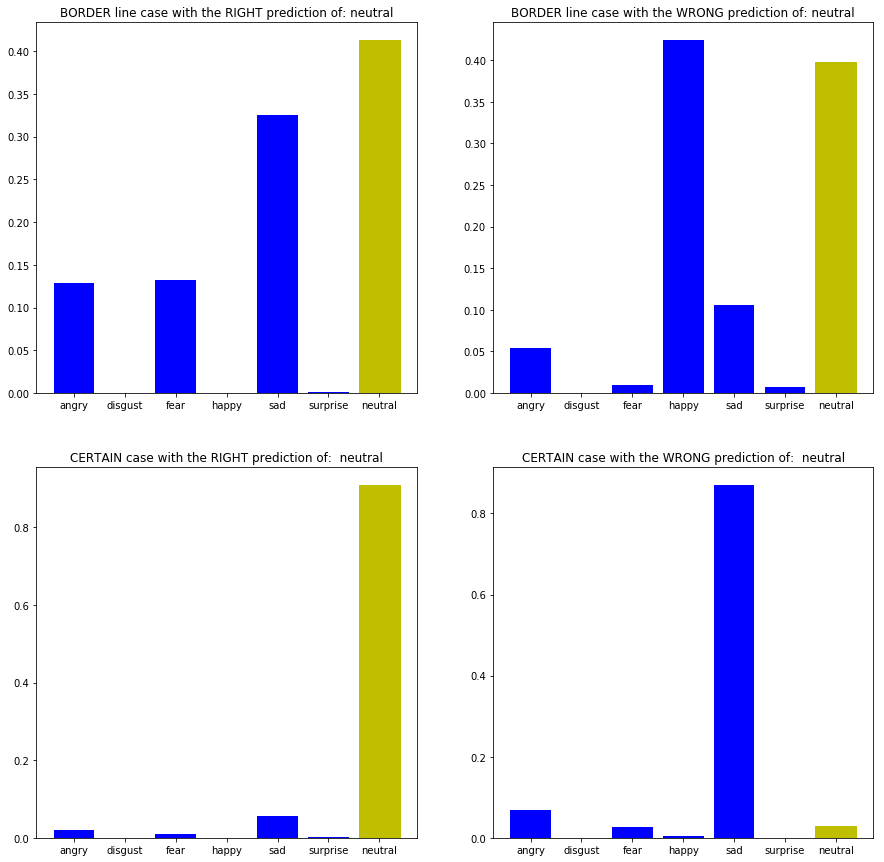

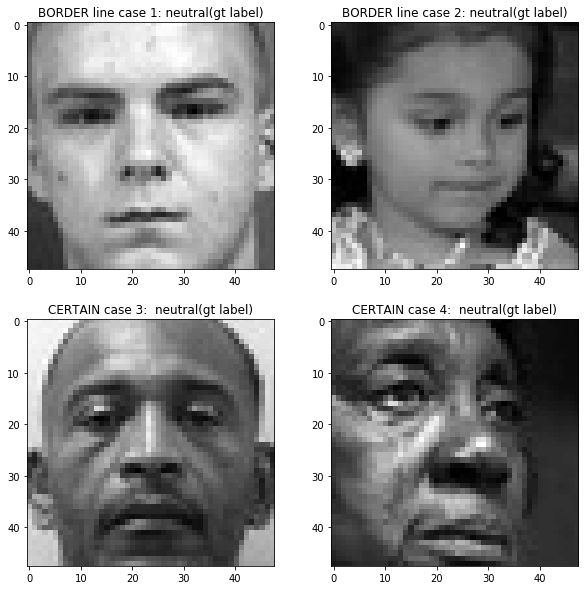

../dataset/kaggle/fer2013/PrivateTest/6/PrivateTest_50149350.jpg
../dataset/kaggle/fer2013/PrivateTest/6/PrivateTest_28451251.jpg
../dataset/kaggle/fer2013/PrivateTest/6/PrivateTest_69935039.jpg
../dataset/kaggle/fer2013/PrivateTest/6/PrivateTest_98615414.jpg


In [9]:
x_label = ['angry','disgust','fear','happy','sad','surprise','neutral'] 
x_index = np.arange(7)
# SOFTMAX
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt_title = "BORDER line case with the RIGHT prediction of: " + emotion_labels[wanted]
index_1 = case1_list[0]
bars_1 = plt.bar(x_index,y_softmax[index_1], width = 0.8, color="blue")
bars_1[wanted].set_color('y')
plt.xticks(x_index, x_label)
plt.title(plt_title)

plt.subplot(2,2,2)
plt_title = "BORDER line case with the WRONG prediction of: " + emotion_labels[wanted]
index_2 = case2_list[0]
bars_2 = plt.bar(x_index,y_softmax[index_2], width = 0.8, color="blue")
bars_2[wanted].set_color('y')
plt.xticks(x_index, x_label)
plt.title(plt_title)

plt.subplot(2,2,3)
plt_title = "CERTAIN case with the RIGHT prediction of:  " + emotion_labels[wanted]
index_3 = case3_list[0]
bars_3 = plt.bar(x_index,y_softmax[index_3], width=0.8, color="blue")
bars_3[wanted].set_color('y')
plt.xticks(x_index, x_label)
plt.title(plt_title)

plt.subplot(2,2,4)
plt_title = "CERTAIN case with the WRONG prediction of:  " + emotion_labels[wanted]
index_4 = case4_list[0]
bars_4 = plt.bar(x_index,y_softmax[index_4], width=0.8, color="blue")
bars_4[wanted].set_color('y')
plt.xticks(x_index, x_label)
plt.title(plt_title)
plt.show()

# ------------------------------------------------------------------ #
# CORRESPONDING IMAGES
case1_img = preprocess._imread(y_file[index_1])
case2_img = preprocess._imread(y_file[index_2])
case3_img = preprocess._imread(y_file[index_3])
case4_img = preprocess._imread(y_file[index_4])

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt_title = "BORDER line case 1: " + emotion_labels[wanted] + "(gt label)"
plt.imshow(case1_img,cmap='gray')
plt.title(plt_title)

plt.subplot(2,2,2)
plt_title = "BORDER line case 2: " + emotion_labels[wanted] + "(gt label)"
plt.imshow(case2_img,cmap='gray')
plt.title(plt_title)

plt.subplot(2,2,3)
plt_title = "CERTAIN case 3:  " + emotion_labels[wanted] + "(gt label)"
plt.imshow(case3_img,cmap='gray')
plt.title(plt_title)

plt.subplot(2,2,4)
plt_title = "CERTAIN case 4:  " + emotion_labels[wanted] + "(gt label)"
plt.imshow(case4_img,cmap='gray')
plt.title(plt_title)
plt.show()


print(y_file[index_1])
print(y_file[index_2])
print(y_file[index_3])
print(y_file[index_4])


# Build 4D image data #

In [10]:
def Build_Data(image, target_size):
    # build data for the train model (resize and normalise scale) 
    img = preprocess._imresize(image,target_size)
    img = preprocess.preprocess_input(img)
    # 4D reshape tensor
    img_data = np.expand_dims(img, 0)
    img_data = np.expand_dims(img_data, -1)
    # make 3 channels data for lime- make 3 channel data
    image_stack = np.append(img_data, img_data[...,0,None], axis=-1)
    image_stack = np.append(image_stack, img_data[...,0,None], axis=-1)
    image_stack = image_stack.astype('float32')
    image_stack = np.asarray(image_stack)
    return image_stack
    

In [11]:
print(case_index)    # case- list(data id)

{1: [2990, 3042, 3084], 2: [3005, 3016, 3023], 3: [2963, 2966, 2969], 4: [3010, 3037, 3104]}


In [12]:
image_data = []
image_indx = []
for i in range(len(case_index)):
    # case in dictionary start from 1
    index_list = case_index[i+1]
    for file_id in index_list :
        filename = y_file[file_id]
        case_img = preprocess._imread(filename)
        case_data = Build_Data(case_img, emotion_target_size)
        image_data.append(case_data)
        image_indx.append(file_id)

n_images = len(image_data)

In [13]:
print(image_indx)

[2990, 3042, 3084, 3005, 3016, 3023, 2963, 2966, 2969, 3010, 3037, 3104]


# Lime Segmentation and Explainer #

In [14]:
explanation_out = []
segmentation_out = []
explainer = lime_image.LimeImageExplainer(data_channel='gray')
for i in range(len(image_data)):
    lime_input = image_data[i]
    # Hide color is the color for a superpixel turned OFF.
    # Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
    explanation,segments_img = explainer.explain_instance(lime_input[0], emotion_classifier.predict, top_labels=7, \
                                             hide_color=0, num_samples=1000,num_features=1000, qs_kernel_size=2)
    
    explanation_out.append(explanation)
    segmentation_out.append(segments_img)

In [15]:
from skimage.segmentation import mark_boundaries

In [ ]:
# 'Green' pixels indicate what has been picked up to support the prediction
# 'Red' pixels inndicate what has been picked up to against the prediction
#  For example: is this face 'angry' (It has some green-yes and red-no) on the image segmentations

SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY
########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: neutral


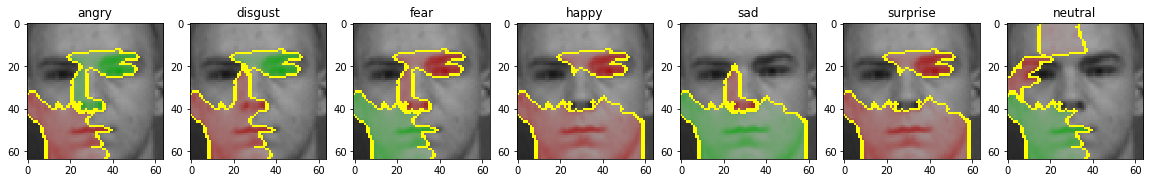

Ground Truth: neutral -----> Model Prediction: neutral


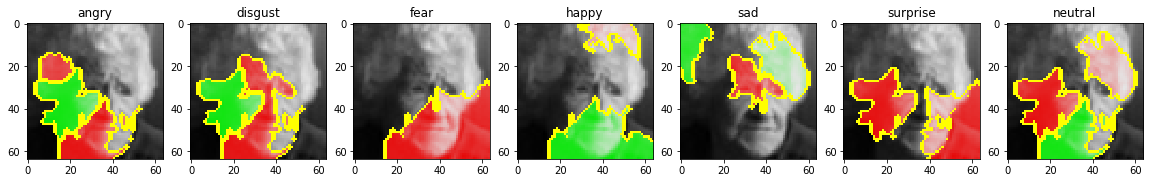

Ground Truth: neutral -----> Model Prediction: neutral


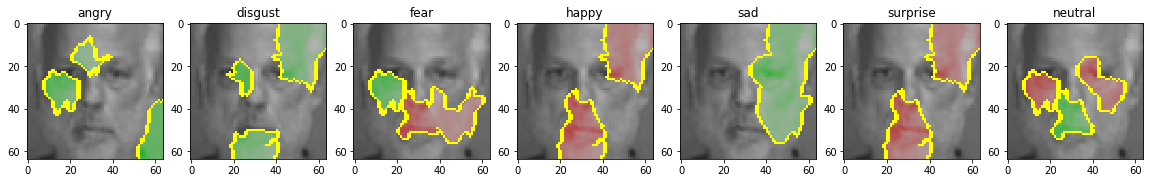

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: happy


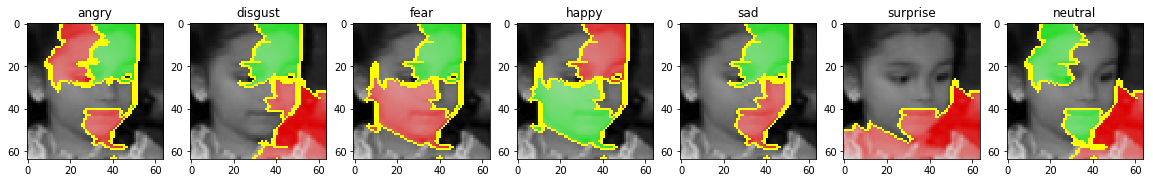

Ground Truth: neutral -----> Model Prediction: fear


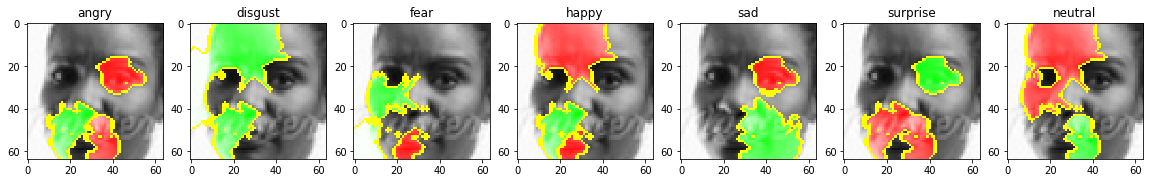

Ground Truth: neutral -----> Model Prediction: sad


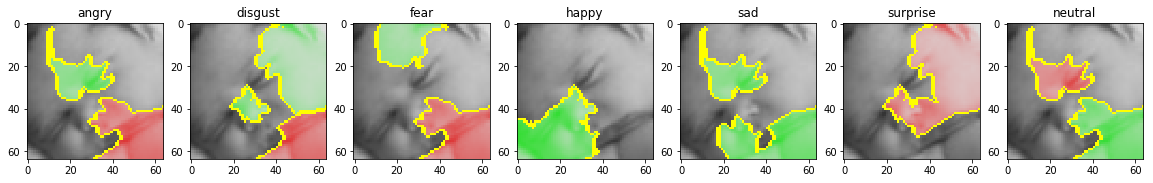

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: neutral


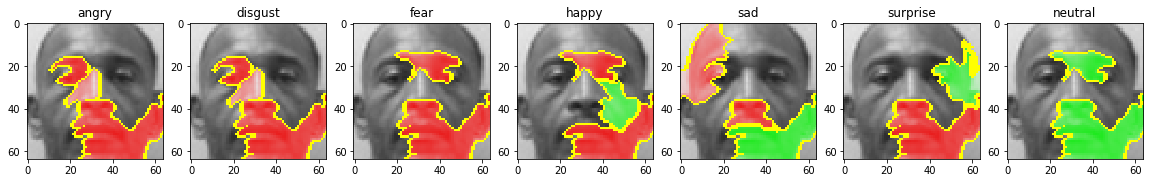

Ground Truth: neutral -----> Model Prediction: neutral


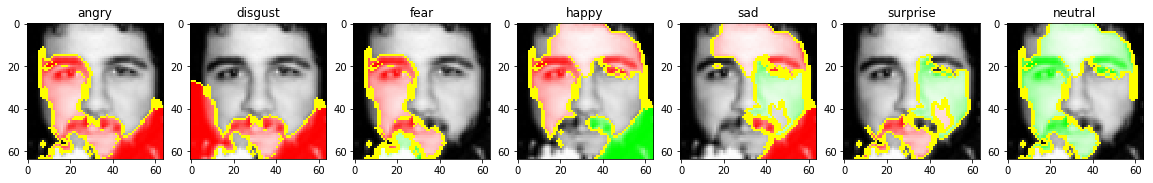

Ground Truth: neutral -----> Model Prediction: neutral


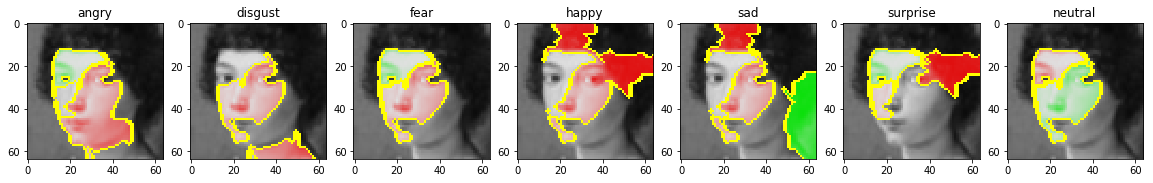

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: sad


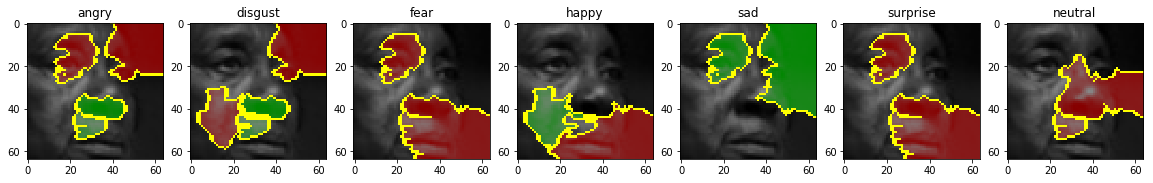

Ground Truth: neutral -----> Model Prediction: happy


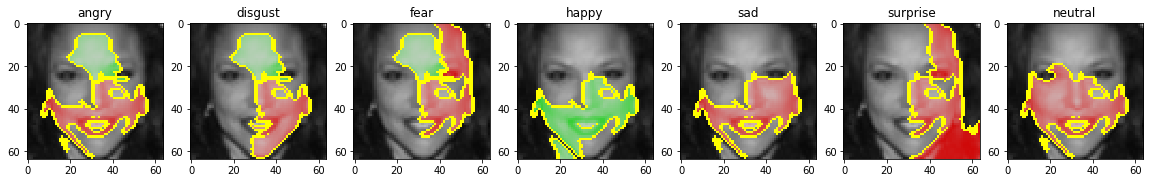

Ground Truth: neutral -----> Model Prediction: sad


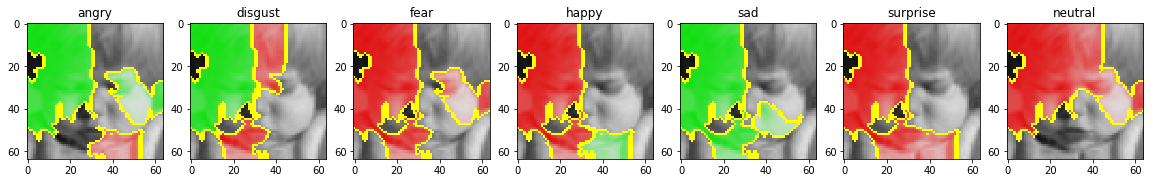

In [16]:
#case_pred_id = [y_pred[index_1],y_pred[index_2],y_pred[index_3],y_pred[index_4]]
print("SHOW POSITIVE/NEGATIVE FEATURES IMAGE OVERLAY")
for k in range(len(image_data)):
    # case explanation
    explanation   = explanation_out[k]
    data_index    = image_indx[k]
    predict_label = y_pred[data_index]
    
    if(not k%n_samples):
        print("########################")
        print("#     CASE ANALYSIS    #")
        print("########################")
        
    print("Ground Truth: {a:s} -----> Model Prediction: {b:s}".format(a=emotion_labels[wanted],\
                                                                      b=emotion_labels[predict_label]) )
    
    # check against each emotion
    plt.figure(figsize=(20,20))
    n_emotions = len(emotion_labels)
    for i in range(n_emotions):
        temp, mask = explanation.get_image_and_mask(i, positive_only=False, num_features=3, hide_rest=False)
        plt.subplot(1,n_emotions,i+1)
        plt.imshow(mark_boundaries(temp/2+0.5, mask))
        plt.title(emotion_labels[i])
    plt.show()

ONLY SHOW POSITIVE FEATURES
########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: neutral


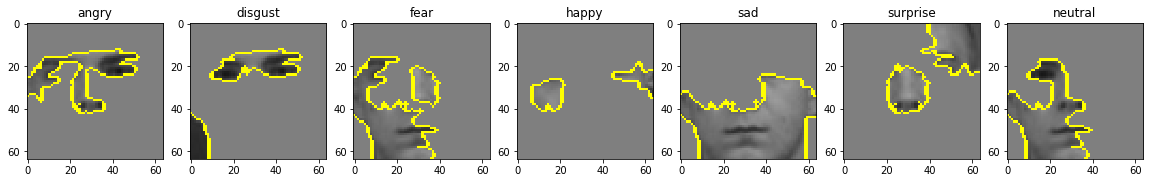

Ground Truth: neutral -----> Model Prediction: neutral


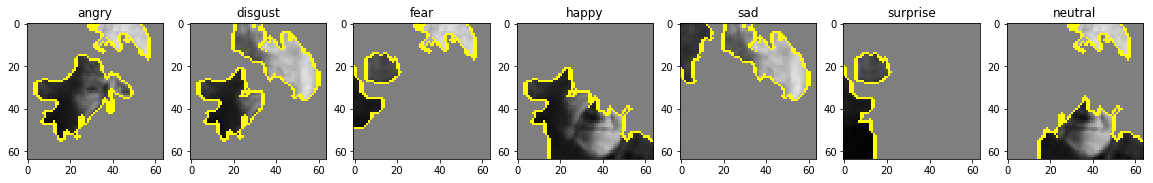

Ground Truth: neutral -----> Model Prediction: neutral


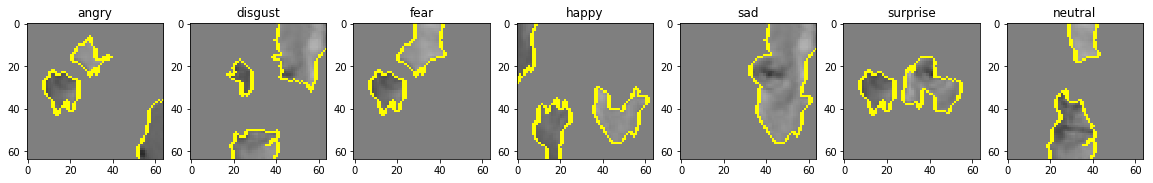

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: happy


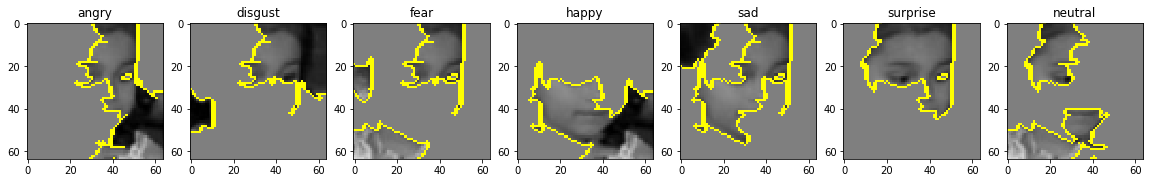

Ground Truth: neutral -----> Model Prediction: fear


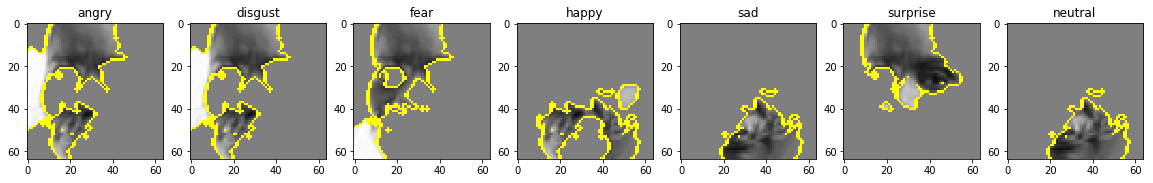

Ground Truth: neutral -----> Model Prediction: sad


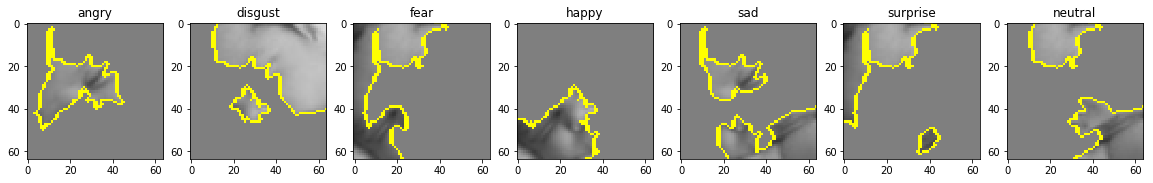

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: neutral


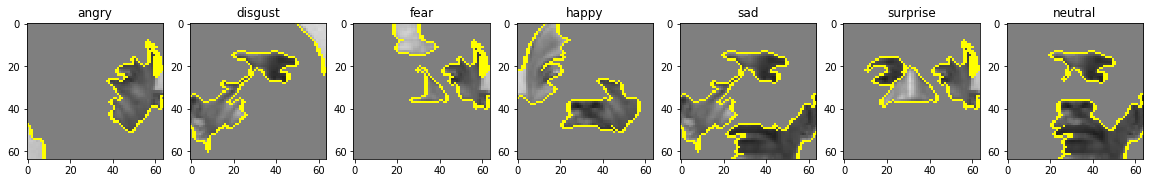

Ground Truth: neutral -----> Model Prediction: neutral


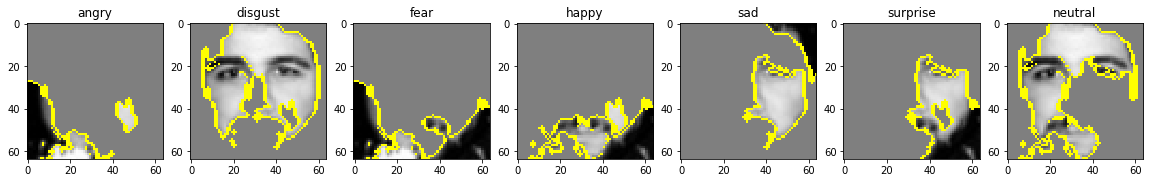

Ground Truth: neutral -----> Model Prediction: neutral


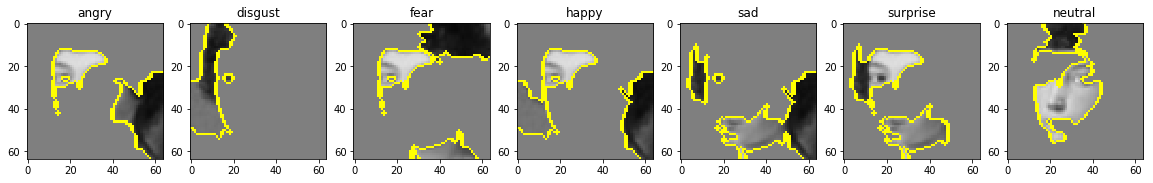

########################
#     CASE ANALYSIS    #
########################
Ground Truth: neutral -----> Model Prediction: sad


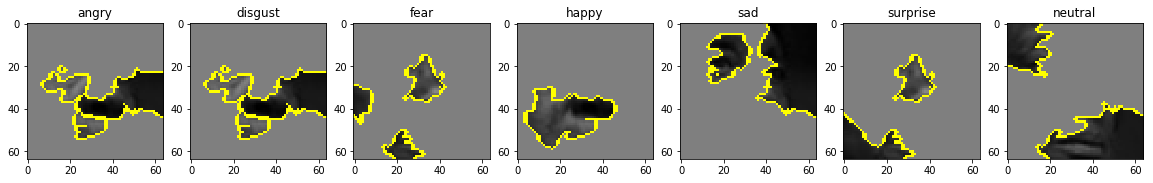

Ground Truth: neutral -----> Model Prediction: happy


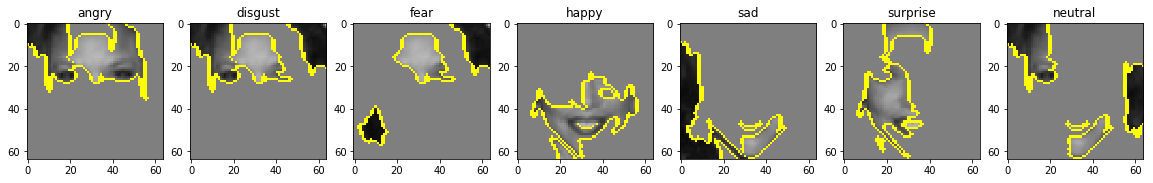

Ground Truth: neutral -----> Model Prediction: sad


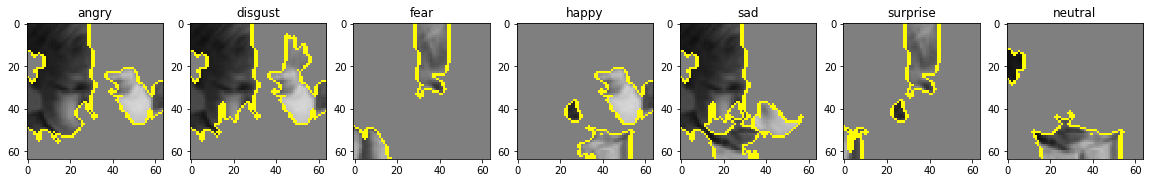

In [17]:
#case_pred_id = [y_pred[index_1],y_pred[index_2],y_pred[index_3],y_pred[index_4]]
print("ONLY SHOW POSITIVE FEATURES")
for k in range(len(image_data)):
    # case explanation
    explanation   = explanation_out[k]
    data_index    = image_indx[k]
    predict_label = y_pred[data_index]
    
    if(not k%n_samples):
        print("########################")
        print("#     CASE ANALYSIS    #")
        print("########################")
        
    print("Ground Truth: {a:s} -----> Model Prediction: {b:s}".format(a=emotion_labels[wanted],\
                                                                      b=emotion_labels[predict_label]) )
    
    # check against each emotion
    plt.figure(figsize=(20,20))
    n_emotions = len(emotion_labels)
    for i in range(n_emotions):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=3, hide_rest=True)
        plt.subplot(1,n_emotions,i+1)
        plt.imshow(mark_boundaries(temp/2+0.5, mask))
        plt.title(emotion_labels[i])
    plt.show()